# Avaliação Sprint 3

## Import das bibliotecas necessárias

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen
from pymongo import MongoClient
import spacy
from spacy import displacy
from spacy.symbols import VERB
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict


## Conexão com o banco de dados Mongo

In [42]:
client = MongoClient("localhost", 27017)
artigos_db = client["Artigos"]
artigos = artigos_db["Coleção_artigos"]
verbos_artigos = artigos_db["Coleção_verbos"]
entidades_artigos = artigos_db["Coleção_entidades"]
resultado_sentimento_artigos = artigos_db["Análise_sentimento_artigos"]

## Fazendo o scrapping dos artigos

In [ ]:
urls = [
    "https://www1.folha.uol.com.br/banco-de-dados/2021/05/1921-transporte-de-cavalos-de-corrida-burla-proibicao-em-sao-paulo.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/06/1921-apos-sucesso-nos-eua-pianista-guiomar-novaes-chega-a-sao-paulo.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/05/1921-missao-italiana-vem-ao-brasil-buscar-ajuda-para-mutilados-na-guerra.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/05/1971-franca-aprova-entrada-do-reino-unido-no-mercado-comum-europeu.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/05/1921-empresa-de-campinas-vai-comecar-a-vender-carne-fresca-a-paulistanos.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/05/1921-teatro-polytheama-em-ribeirao-preto-e-destruido-por-incendio.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/04/1921-tracado-de-estrada-que-ligara-limeira-a-araras-e-estudado.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/03/1971-guerra-civil-estoura-no-paquistao-oriental-que-deseja-independencia.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/03/1921-estrada-vai-facilitar-ligacao-de-sao-paulo-com-triangulo-mineiro-e-goias.shtml",
    "https://www1.folha.uol.com.br/banco-de-dados/2021/02/1921-autoridade-do-reino-unido-reafirma-luta-contra-movimento-irlandes.shtml"
] # lista das urls dos artigos



In [24]:
lista_artigos = []
for url in urls:
    response = urlopen(url)
    html = response.read().decode('utf8')

    soup = BeautifulSoup(html, 'html.parser')

    # Extraindo o texto de cada paragrafo dos artigos, sem as tags html
    paragrafos_artigo = [paragrafo.text for paragrafo in soup.find('div', {'class': 'c-news__body'}).findAll('p')]

    lista_artigos.append({'Paragrafos': paragrafos_artigo})



In [25]:
lista_artigos

[{'Paragrafos': ['Está sendo burlada a proibição de transportar animais nas estradas que convergem a São Paulo.',
   'Dias depois do aparecimento da peste bovina nos arredores da capital, as autoridades sanitárias tinham lembrado o governo da necessidade de estabelecer essa proibição.',
   'Apesar da medida, jornais noticiaram a ida e vinda de cavalos de corrida entre a capital e Santos. A fim de mascarar a manobra, os animais são enviados para São Bernardo e de lá são transportados para a outra cidade.',
   'Isso ocorre como se a transmissão da peste não fosse possível nas patas de cavalos ingleses, que custam caro.']},
 {'Paragrafos': ['A pianista Guiomar Novaes chegou a São Paulo nesta quinta-feira (2). Ela veio em um trem noturno do Rio de Janeiro, após regressar de uma viagem triunfal aos Estados Unidos, onde foi considerada, por vários críticos, a maior virtuose do mundo.',
   'Guiomar Novaes tinha viajado para os EUA em dezembro de 1920 para realizar uma série de concertos, mas 

## Salvando os artigos no MongoDB

In [26]:
artigos.insert_one({'Artigos': lista_artigos})


## Criando um dataset com os paragrafos dos artigos

In [27]:
paragrafos_artigos = artigos.find({'Artigos': lista_artigos}) # Retirando os paragrafos direto do mongo
for paragrafo in paragrafos_artigos:
    # Os paragrafos são transformados em dataframe
    df_paragrafos = pd.DataFrame(paragrafo['Artigos'])


df_paragrafos.head()

,Paragrafos
0,[Está sendo burlada a proibição de transportar...
1,[A pianista Guiomar Novaes chegou a São Paulo ...
2,[A missão italiana de mutilados na guerra cheg...
3,[A França deu o seu “sim” para o ingresso do R...
4,"[Uma empresa particular, de Campinas, vai pass..."


In [ ]:
nlp = spacy.load("pt_core_news_sm")
doc = nlp(str(df_paragrafos.Paragrafos))

## Retirando as stop words

In [ ]:
def retira_stop_words(artigos):
    palavras_tokens = []

    # Transforma cada palavra do artigo em token
    nlp = spacy.load("pt_core_news_sm") # nlp em português
    doc = nlp(str(artigos))

    for palavra_token in doc:
        palavra = not palavra_token.is_stop and palavra_token.is_alpha

        if palavra:
            # Adiciona na lista e deixa a palavra em minusculo
            palavras_tokens.append(palavra_token.text.lower())
    
    return ' '.join(palavras_tokens)

In [ ]:
artigos_processados = []

for paragrafos in df_paragrafos.Paragrafos:
    artigos_processados.append(retira_stop_words(paragrafos))

In [28]:
df_paragrafos["Paragrafos_processados"] = artigos_processados
df_paragrafos.head()

,Paragrafos,Paragrafos_processados
0,[Está sendo burlada a proibição de transportar...,sendo burlada proibição transportar animais es...
1,[A pianista Guiomar Novaes chegou a São Paulo ...,pianista guiomar novaes chegou paulo veio trem...
2,[A missão italiana de mutilados na guerra cheg...,missão italiana mutilados guerra chegou rio ja...
3,[A França deu o seu “sim” para o ingresso do R...,frança deu ingresso reino unido mercado comum ...
4,"[Uma empresa particular, de Campinas, vai pass...",empresa particular campinas passar vender carn...


## Obtendo os verbos e as entidades

In [29]:
# Listando os verbos
lista_verbos = []
nlp = spacy.load("pt_core_news_sm") # nlp em português
doc = nlp(str(lista_artigos))

for palavra in doc:
    if palavra.head.pos == VERB:
        if palavra.head.orth_ not in lista_verbos:
            # Transforma em string e adiciona na lista de verbos
            lista_verbos.append(str(palavra.head))

lista_verbos
verbos_artigos.insert_one({'Verbos': lista_verbos})

In [30]:
# Listando as entidades
for palavra in range(len(lista_artigos)):
    doc = nlp(str(lista_artigos[palavra]))
    entidades = doc.ents
    entidades_artigos.insert_one({'Entidades': str(entidades)})

for palavra in range(len(lista_artigos)):
    doc = nlp(str(lista_artigos[palavra]))
    displacy.render(doc, style='ent', jupyter=True)
    print('\n \n')

## Gerando uma núvem de palavras

In [ ]:
# Função gerar núvem de palavras
def gerar_nuvem_palavras(artigos):
    todas_palavras = ''.join([text for text in artigos])
    nuvem_palavras = WordCloud(width=800, 
                            height=500,
                            max_font_size=110,
                            collocations=False).generate(todas_palavras)
                            
    plt.figure(figsize=(10,7)) # Tamanho da figura
    plt.imshow(nuvem_palavras)
    plt.axis("off") # Plota apenas a imagem, fora do plano cartesiano
    plt.show()

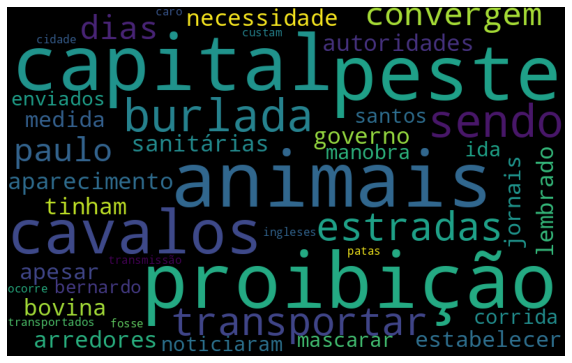

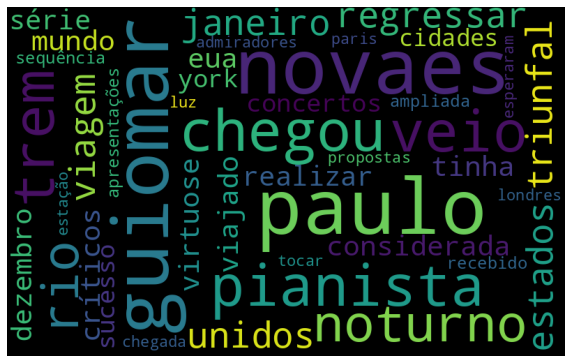

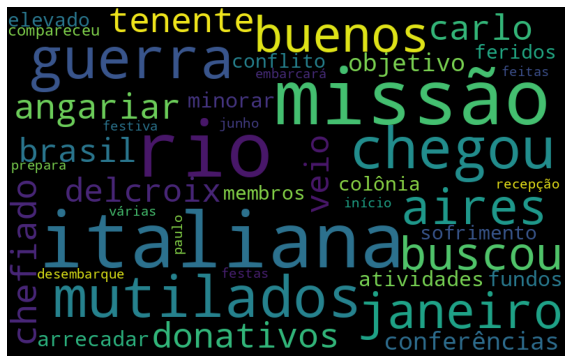

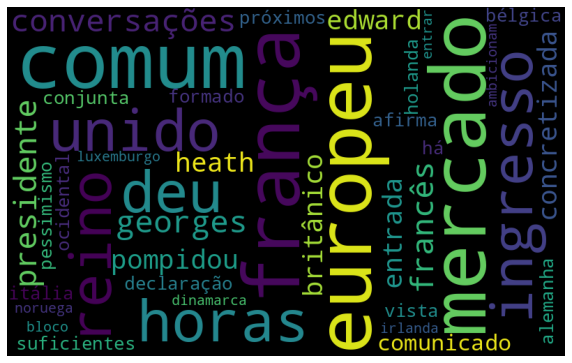

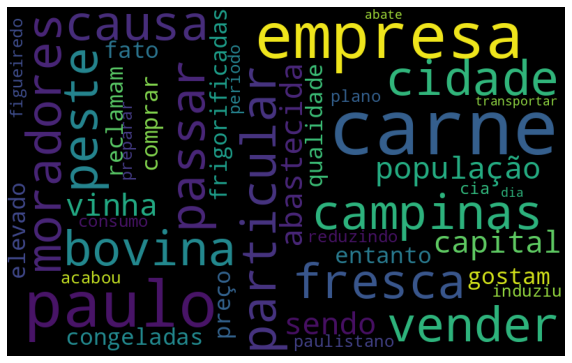

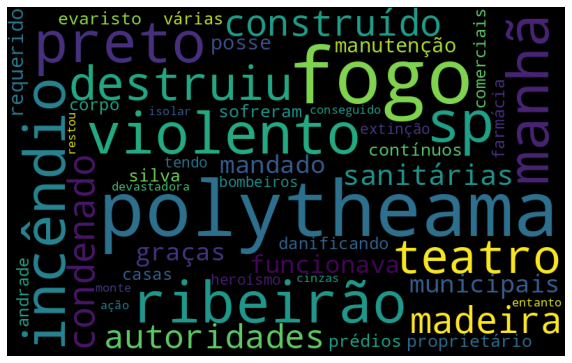

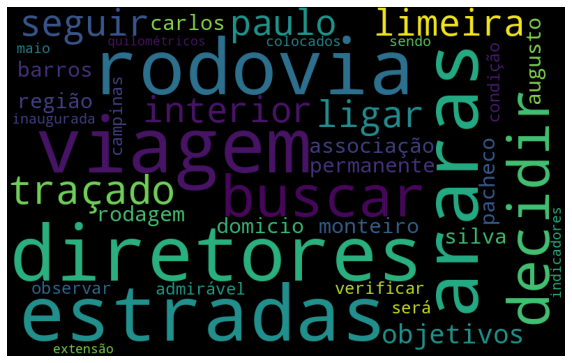

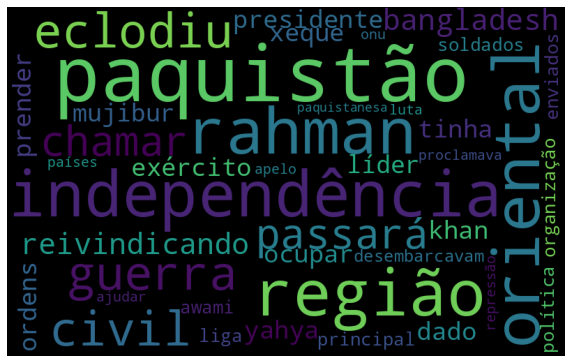

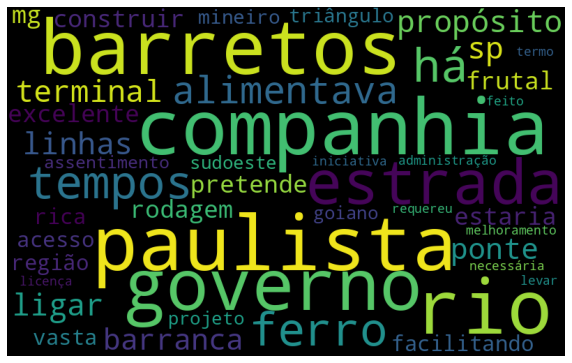

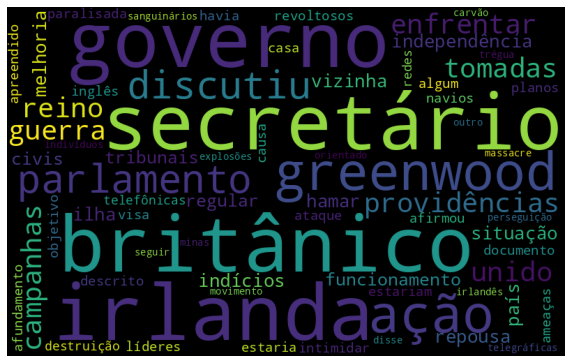

In [31]:
for i in range(0, 10):
    paragrafo_artigo = str(df_paragrafos.Paragrafos_processados[i])
    gerar_nuvem_palavras(paragrafo_artigo)

## Treinamento do dataset - Tweeter

In [32]:
#Importando o dataset
tweets_df = pd.read_csv('Tweets_Mg.csv')
tweets_df.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Separando apenas as colunas que serão usadas
# Text => tweet
# Classificacao => Sentimentos (pos, neg, neutro)
tweets = tweets_df[['Text', 'Classificacao']]
tweets.head()

,Text,Classificacao
0,���⛪ @ Catedral de Santo Antônio - Governador ...,Neutro
1,"� @ Governador Valadares, Minas Gerais https:/...",Neutro
2,"�� @ Governador Valadares, Minas Gerais https:...",Neutro
3,��� https://t.co/BnDsO34qK0,Neutro
4,��� PSOL vai questionar aumento de vereadores ...,Negativo


In [34]:
# Contando a quantidadade de tweets Positivo, Neutro e Negativo
tweets.Classificacao.value_counts()

Positivo    3300
Neutro      2453
Negativo    2446
Name: Classificacao, dtype: int64

In [35]:
# Obtendo os valores dos tweets e transformando-os em arrays numpy
tweets_treino = tweets.values
print(f'Textos: {tweets_treino[:,0]}')
print('\n \n')
print(f'Sentimentos: {tweets_treino[:,1]}')




Textos: ['���⛪ @ Catedral de Santo Antônio - Governador Valadares/MG https://t.co/JSbKamIqUJ'
 '� @ Governador Valadares, Minas Gerais https://t.co/B3ThIDJCSf'
 '�� @ Governador Valadares, Minas Gerais https://t.co/dPkgzVR2Qw' ...
 'Trio é preso suspeito de roubo, tráfico e abuso sexual em Uberlândia https://t.co/zaQbXRRJWc'
 'Trio é preso suspeito de roubo, tráfico e abuso sexual em Uberlândia: Um dos autores teria molestado vítima de… https://t.co/lQ8cTSNftA'
 'Trio suspeito de roubo de cargas é preso em Santa Luzia (MG) https://t.co/0INgJcMtZb #R7MG #RecordTVMinas']

 

Sentimentos: ['Neutro' 'Neutro' 'Neutro' ... 'Positivo' 'Positivo' 'Positivo']


In [36]:
#Vetor com cada uma das palavras dos tweets
vectorizer = CountVectorizer(analyzer='word')

# Calculando a frequência em que cada palavra ocorre
freq_tweets = vectorizer.fit_transform(tweets_treino[:,0])

# Criando um modelo de treinamento
modelo = MultinomialNB()
modelo.fit(freq_tweets, tweets_treino[:,1])

#Medindo a acurácia
resultados = cross_val_predict(modelo, freq_tweets, tweets_treino[:,1], cv = 10)
acuracia = metrics.accuracy_score(tweets_treino[:,1], resultados) * 100

print(f'{acuracia}%')

88.31564824978656%


## Fazendo a análise de sentimentos nos artigos


In [40]:
artigos_para_testes = []
for artigo in df_paragrafos.Paragrafos_processados:
    artigos_para_testes.append(str(artigo))

artigos_para_testes

['sendo burlada proibição transportar animais estradas convergem paulo dias aparecimento peste bovina arredores capital autoridades sanitárias tinham lembrado governo necessidade estabelecer proibição apesar medida jornais noticiaram ida cavalos corrida capital santos mascarar manobra animais enviados bernardo transportados cidade ocorre transmissão peste fosse patas cavalos ingleses custam caro',
 'pianista guiomar novaes chegou paulo veio trem noturno rio janeiro regressar viagem triunfal estados unidos considerada críticos virtuose mundo guiomar novaes tinha viajado eua dezembro realizar série concertos sucesso york cidades sequência apresentações ampliada recebido propostas tocar londres paris chegada paulo admiradores esperaram estação luz',
 'missão italiana mutilados guerra chegou rio janeiro buenos aires buscou angariar donativos chefiado tenente carlo delcroix veio brasil objetivo conferências atividades arrecadar fundos minorar sofrimento feridos conflito elevado membros colô

In [44]:
freq_testes = vectorizer.transform(artigos_para_testes)
resultado_analise = modelo.predict(freq_testes)
resultado_analise

array(['Neutro', 'Neutro', 'Neutro', 'Neutro', 'Neutro', 'Positivo',
       'Neutro', 'Neutro', 'Neutro', 'Neutro'], dtype='<U8')

In [46]:
resultado_sentimento_artigos.insert_one({'Analise_sentimento': str(resultado_analise)})